In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import scipy.integrate as integrate
import time
size = 6
cm = 0.393701

## Symbolic Expression for forward model and its Adjoint equation

In [2]:
import sympy as sp

def forward_symb(D, P):
    x, t, f, L = sp.symbols('x t f L(f)')
    num_terms = (D+1)*P + 1

    coeffs = sp.symbols('α:' + str(num_terms), real=True)
    L_f = sp.Derivative(f, t) + coeffs[-1] 

    for d in range(D+1):
        for p in range(1, P+1):
            coeffs_idx = d*P + (p-1)
            L_f += coeffs[coeffs_idx] * sp.Derivative(f**p, x, d)

    return sp.Eq(L, L_f)

def adjoint_eq_symb(D, P):
    x, t, f, fs, lam = sp.symbols('x t f f^* λ')
    num_terms = (D+1)*P 

    coeffs = sp.symbols('α:' + str(num_terms), real=True)
    LHS = sp.Derivative(lam, t)
    RHS = -2 * (fs - f)

    for d in range(D+1):
        for p in range(1, P+1):
            coeffs_idx = d*P + (p-1)
            RHS += (-1)**d * coeffs[coeffs_idx] * p * f**(p-1) * sp.Derivative(lam, x, d)

    return sp.Eq(LHS, RHS)

D, P = 2, 1
print('Forward Model:')
display(forward_symb(D, P))

print('Adjoint Equation:')
display(adjoint_eq_symb(D, P))

Forward Model:


Eq(L(f), f*α0 + α1*Derivative(f, x) + α2*Derivative(f, (x, 2)) + α3 + Derivative(f, t))

Adjoint Equation:


Eq(Derivative(λ, t), 2*f - 2*f^* + α0*λ - α1*Derivative(λ, x) + α2*Derivative(λ, (x, 2)))

## Solving forward model and its adjoint equation using finite difference

In [2]:
# Forward model with an expansion of all possible terms
def forward_m(params, ps, ds, f0, dx, dt, Nt):
    ## Inputs:
    #  params (numPDE, len(ds), P)
    #  ps is a list of powers for f
    #  e.g. [(0,0), (1,0), (2,1)] is 1, f_0, f_0^2*f_1
    #  ds is a list of derivative index tuples.
    #  e.g. [(0,0), (1,0), (2,0)] for f, df/dx0, d^2f/dx0^2
    #  f0 (numPDE, Nx1, Nx2, ...)
    #  dx (dx0, dx1, ...)
    ## Output:
    #  f (numPDE, Nt, Nx1, Nx2, ...)
    numPDE = f0.shape[0]
    grid_shape = f0[0,:].shape
    f = np.zeros( (numPDE,) + (Nt,) + grid_shape )
    f[:,0,:] = f0
    for i in range(Nt-1):
        f[:,i+1,:] = f[:,i,:]
        for i_pde in range(numPDE):
            for i_p, p in enumerate(ps):
                for i_d, d in enumerate(ds): ## for each d of ds, compute nabla^{d} [f^p] contribution
                    temp = np.ones_like(f[0, i, :])
                    for i_pi, pi in enumerate(p):
                        temp *= f[i_pi, i, :] ** pi
                    for i_di, di in enumerate(d): ## for each element di of d=(d0,d1,...)
                        for _ in range(1, di+1): ## take di derivatives
                            temp = np.gradient(temp, axis=i_di)/dx[i_di]
                    # multiply to its parameter, then add to the whole expression
                    f[i_pde, i+1,:] -= params[i_pde, i_d, i_p] * temp * dt
    return f

# Adjoint equation for the Lagarange multiplier
def adjoint_eq(params, P, ds, fs, f, dx, dt, Nt):
    ## Inputs:
    #  params (numPDE, len(ds), P)
    #  ps is a list of powers for f
    #  e.g. [(0,0), (1,0), (2,1)] is 1, f_0, f_0^2*f_1
    #  ds is a list of derivative index tuples.
    #  e.g. [(0,0), (1,0), (2,0)] for f, df/dx1, d^2f/dx^2
    #  fs (numPDE, Nt, Nx1, Nx2, ...)
    #  f (numPDE, Nt, Nx1, Nx2, ...)
    #  dx (dx0, dx1, ...)
    ## Output:
    #  lam (numPDE, Nt, Nx0, Nx1, ...)
    numPDE = f.shape[0]
    lam = np.zeros(f.shape)
    lam[:, -1, :] = 2 * (fs[:, -1, :] - f[:, -1, :])
    for i in range(Nt - 1, 0, -1):
        lam[:, i-1, :] = lam[:, i, :] + 2 * (fs[:, i, :] - f[:, i,:]) * dt
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):## for each d of ds, compute nabla^{d}[lambda] contribution
                temp = lam[i_pde, i, :]
                for i_di, di in enumerate(d): ## for each element di of d=(d0,d1,...)
                    for _ in range(1, di+1):
                        temp = np.gradient(temp, axis=i_di)/dx[i_di]
                temp *= (-1)**(sum(d))
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(f[0, i, :])
                    for i_pi, pi in enumerate(p):
                        if i_pi != i_pde:
                            tempf *= f[i_pi, i, :] ** pi
                        else:
                            if pi>0: # take derivative if f_i has power > 0
                                tempf *= pi *  f[i_pi, i, :] ** (pi-1)
                            else:
                                tempf *= 0. ## set derivative to zero when f^p does not have any term with f_i
                    lam[i_pde, i-1,:] -= params[i_pde, i_d, i_p] * tempf * temp * dt
    return lam

def generate_combinations(num_loops, num_entries):
    combinations = []

    def generate_combination_helper(current_combination, remaining_loops):
        if remaining_loops == 0:
            combinations.append(current_combination.copy())
            return
        for entry in range(num_entries + 1):
            current_combination.append(entry)
            generate_combination_helper(current_combination, remaining_loops - 1)
            current_combination.pop()

    generate_combination_helper([], num_loops)
    unique_set = {tuple(sublist) for sublist in combinations}
    unique_list = [list(sublist) for sublist in unique_set]
    filtered_list = [sublist for sublist in unique_list if sum(sublist) <= num_entries]

    return filtered_list

## Heat Equation

### Generate Data

(1, 1000)
(1, 1000)
(1, 1000, 1000)


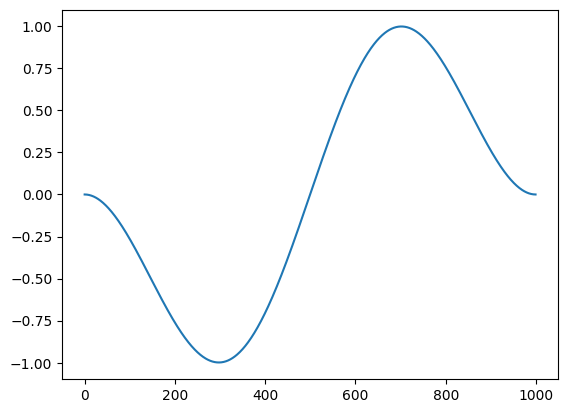

In [257]:
## generate data
# df/dt + D d2f/dx^2 = 0

CFL = 0.05
def dt_cfl(dx, D_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx**2/(1.+abs(D_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def heat_equation(D_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - D_m * np.gradient(np.gradient(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
D_ex = -1.0  # Thermal diffusivity

dx = L/Nx
dt = dt_cfl(dx, D_ex)
Nt = 100
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = heat_equation(D_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

print(x.shape)
print(f0.shape)
print(fs.shape)
plt.plot(f0[0])

fs0 = fs.copy()

### Adjoint method

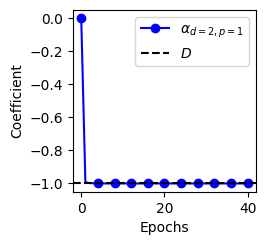

Execution time: 67.50938534736633
total number of terms: 9
3.83918371332839e-10


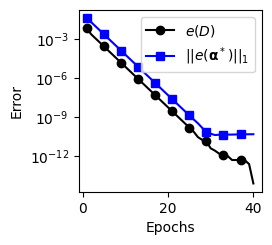

In [258]:
noise = 0.0/100. # added noise as standard deviation of the normal distribution
problem = "1D_heat_equation_noise"
tol = 1e-12
start_time = time.time()
numPDE = fs.shape[0]

fs = fs0.copy()
fs = fs*(1+np.random.normal(0.0, noise, fs.shape) )

V = L
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])
D = np.max(np.sum(ds,axis=1))
P = np.max(np.sum(ps,axis=1))

params = np.zeros((numPDE,len(ds),len(ps)))
beta = 0.1
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) )
epochs = 100
estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

params0 = params
for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2,:]
        ft0 = fst[:, 0,:]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params
    if np.linalg.norm(params-params0) < tol:
        epochs = ep
        break
    params0 = params

eps = [i for i in range(epochs)]

estimated_params = estimated_params[:epochs,:] 

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==2 and p[0]==1 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker="o", markevery=4)
            err_D = estimated_params[-1,i_pde,id,ip]
err_D = abs(err_D - D_ex)
plt.axhline(D_ex, linestyle = "--", color="black", label=r"$D$")
plt.legend()
plt.ylabel(r'Coefficient')
plt.xlabel('Epochs')
name = problem + "_" + "Dconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==2 and p[0]==1 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),#/abs(D_ex),
                     label=r"$e(D)$", marker="o", markevery=4, color="black")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="blue", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "D"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))
print((err_other[-1])+err_D)


In [39]:
fs-fs0

array([[[ 0.00000000e+00,  8.52476200e-06, -8.07921976e-06, ...,
          1.66958492e-05,  3.40114685e-07,  0.00000000e+00],
        [ 8.43716776e-08,  4.51290031e-06, -3.58125535e-06, ...,
         -9.61393115e-06,  4.20357941e-06, -3.59303134e-08],
        [ 1.46729645e-07,  6.37572114e-07,  9.08337918e-06, ...,
          1.51420533e-06,  8.02938251e-07,  1.70643917e-07],
        ...,
        [ 7.12170502e-06, -2.32009436e-05, -4.76718758e-05, ...,
         -3.66355291e-05, -2.96934422e-06,  6.07536665e-06],
        [-1.08075313e-06, -1.75250286e-05,  5.50234549e-05, ...,
          1.77731618e-06, -1.75382966e-05,  6.13438198e-06],
        [ 2.70706974e-06, -2.05027540e-05,  5.32630821e-05, ...,
         -1.30430192e-05, -2.42728944e-05, -7.49123528e-06]]])

### Using FIND-PDE

In [260]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

fs = fs0.copy()
fs = fs*(1+np.random.normal(0.0, noise, fs.shape) )
start_time = time.time()

'''
Ut, R, rhs_des = build_linear_system(fs[0], dt, dx[0], D=3, P=3, time_diff = 'FD', space_diff = 'FD')
print(['1'] + rhs_des[1:])
w = TrainSTRidge(R, Ut, 10**1, 0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)
'''

import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))


for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-6,0.1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
print(coeff_pdefind[0])
print(np.sum(coeff_pdefind[1:]) + abs(-coeff_pdefind[0]-D_ex))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (1.000000 +0.000000i)u_{xx}
    + (-0.000001 +0.000000i)u
    + (0.000001 +0.000000i)u^3
    + (0.000000 +0.000000i)uu_{x}
    + (-0.000000 +0.000000i)u^3u_{x}
    + (0.000000 +0.000000i)u^2u_{xx}
    + (0.000000 +0.000000i)uu_{xxx}
    + (-0.000000 +0.000000i)u^3u_{xxx}
   
Execution time: 512.390477180481
[1.]
[2.49875965e-06]


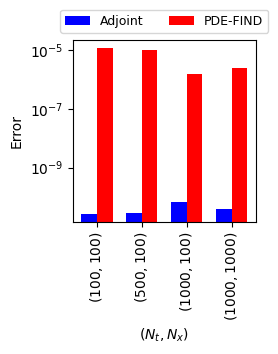

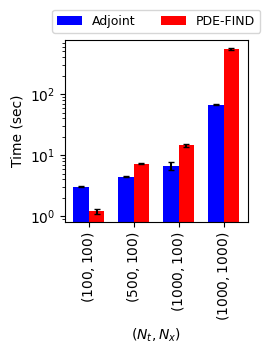

In [9]:
err_adjoint = np.array([ 2.7077e-11  ,2.92299e-11 , 7.0218e-11 ,3.8391e-11 ])
err_pdefind = np.array([ 1.1287e-05  ,1.01273e-05 , 1.4963e-06 , 2.49875965e-06])

t_adjoint = np.array([ 3.06 , 4.45, 6.619, 67.5  ])
t_pdefind = np.array([ 1.2, 7.22 , 14.5, 542.6 ])
t_adjoint_bars = np.array([0.1, 0.1, 1, 2])
t_pdefind_bars = np.array([0.1, 0.1, 1, 20])

discr_ = [r'$(100,100)$', r'$(500,100)$', r'$(1000,100)$', r'$(1000,1000)$']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "HeatEqError"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)


plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, t_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint", yerr=t_adjoint_bars)
plt.bar(bar_positions2, t_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND", yerr=t_pdefind_bars)
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Time (sec)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "HeatEqTime_notlog"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## Burger's equation

### Generate data

(1, 100)
(1, 100)
(1, 1000, 100)


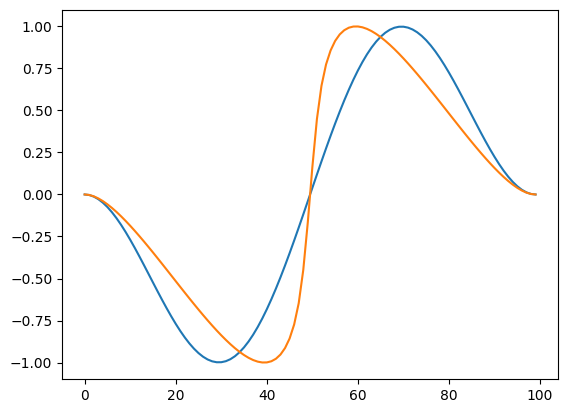

In [236]:
## generate data
# df/dt + A*f*df/dx = 0

CFL = 0.01
def dt_cfl(dx, A_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx/(1.+abs(A_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def burger_equation(A_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - np.gradient( A_m*f_m[i,:]**2)/dx_m * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient

dx = L/Nx
dt = dt_cfl(dx, A_ex)
Nt = 1000
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = burger_equation(A_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()

print(x.shape)
print(f0.shape)
print(fs.shape)
plt.plot(fs[0,0,:])
plt.plot(fs[0,-1,:])

### Adjoint Method

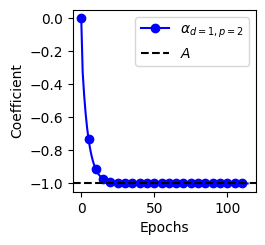

Execution time: 14.664926052093506
total number of terms: 9
4.260053044069941e-12


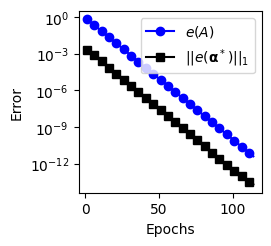

In [226]:
noise = 0.0/100. # added noise as standard deviation of the normal distribution
problem = "1D_burgers_eq_noise"

fs = fs0.copy()
fs = fs*(1+np.random.normal(0.0, noise, fs.shape) )

tol = 1e-12
start_time = time.time()
numPDE = fs.shape[0]

V = L
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])
D = np.max(np.sum(ds,axis=1))
P = np.max(np.sum(ps,axis=1))

params = np.zeros((numPDE,len(ds),len(ps)))
beta = 0.001
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        #learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) )
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)- D) ) #*2**(P-sum(p))
epochs = 200
estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

params0 = params
for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2,:]
        ft0 = fst[:, 0,:]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params
    if np.linalg.norm(params-params0) < tol:
        epochs = ep
        break
    params0 = params

eps = [i for i in range(epochs)]
estimated_params = estimated_params[:epochs,:] 

i_pde = 0

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==1 and p[0]==2 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue",marker="o", markevery=5)
            total_error = estimated_params[-1,i_pde,id,ip]
total_error = abs(total_error-A_ex)
plt.axhline(A_ex, color="black", linestyle = "--", label=r"$A$")
plt.ylabel('Coefficient')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "Aconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))


err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==1 and p[0]==2 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1
      
#problem = "1D_burger_equation"
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),#/abs(D_ex),
                     label=r"$e(A)$", marker="o", markevery=5, color="blue")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=5, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "A"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

total_error += err_other[-1]
print(total_error)

#print(params)
#print(learning_rates)

### FIND-PDE

In [239]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

fs = fs0.copy()
fs = fs*(1+np.random.normal(0.0, noise, fs.shape) )

start_time = time.time()

'''
Ut, R, rhs_des = build_linear_system(fs[0], dt, dx[0], D=3, P=3, time_diff = 'FD', space_diff = 'FD')
print(['1'] + rhs_des[1:])
w = TrainSTRidge(R, Ut, 10**1, 0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)
'''

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))


for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-5,1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
error = abs(-coeff_pdefind[0] - 2*A_ex)
error += np.sum(abs(coeff_pdefind[1:]))
print(error)

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'u^2', 'u^3', 'uu_{x}', 'u^2u_{x}', 'u^3u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'u^3u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'u^3u_{xxx}']
u_t = (0.001245 +0.000000i)u_{xx}
    + (0.229404 +0.000000i)u^3
    + (2.021920 +0.000000i)uu_{x}
    + (0.003402 +0.000000i)u^2u_{xx}
    + (0.000074 +0.000000i)uu_{xxx}
   
Execution time: 15.297326803207397
[4.2535543]


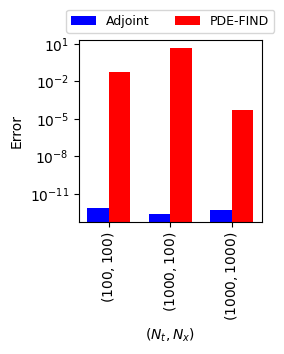

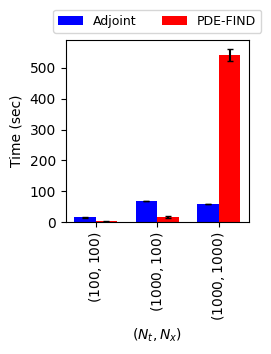

In [243]:
err_adjoint = np.array([ 7.260e-13 , 2.55e-13,  5.244e-13])
err_pdefind = np.array([ 0.05006 , 4.25 , 4.686e-05])


t_adjoint = np.array([14.66 , 67.8, 58.15 ])
t_pdefind = np.array([2.2, 15.9, 542.1])
t_adjoint_bars = np.array([1, 1, 1])
t_pdefind_bars = np.array([1, 2, 20])

discr_ = [r'$(100,100)$', r'$(1000,100)$', r'$(1000,1000)$']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "BurgersEqError"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)


plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, t_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint", yerr=t_adjoint_bars)
plt.bar(bar_positions2, t_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND", yerr=t_pdefind_bars)
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Time (sec)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "BurgersEqTime"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## Kuramoto Sivashinsky Equation

(1, 1024)
(1, 1024)
(1, 256, 1024)


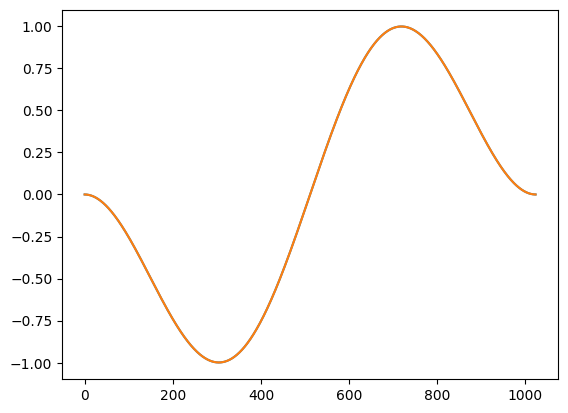

In [176]:
from numpy import gradient as grad
# ut + A*uxxxx + B*u*ux + D*uxx = 0
def dt_cfl(dx, C_m):
    # dt of simulation should be set satisfying CFL condition for stability
    CFL = 0.01
    return CFL*dx**4/(1.+abs(C_m))
    
def Kuramoto_Sivashinsky_equation(A_m, B_m, C_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:]
        f_m[i+1,:] += - C_m * grad(grad(grad(grad(f_m[i,:]))))/dx_m**4 * dt_m        
        f_m[i+1,:] += - A_m * grad(f_m[i,:]**2)/dx_m * dt_m 
        f_m[i+1,:] += - B_m * grad(grad(f_m[i,:]))/dx_m**2 * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 1024  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient
B_ex = 0.5
C_ex = -0.5

dx = L/Nx
dt = dt_cfl(dx, C_ex)
Nt = 256
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = Kuramoto_Sivashinsky_equation(A_ex, B_ex, C_ex, f0, dx, dt, Nt) #*np.random.normal(0.,0.001,(Nt,Nx)) # (Nt, Nx)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()


print(x.shape)
print(f0.shape)
print(fs.shape)
plt.plot(fs[0,0,:])
plt.plot(fs[0,-1,:])

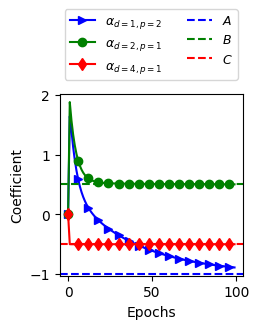

Execution time: 37.76945424079895
total number of terms: 8
0.11401670207305951


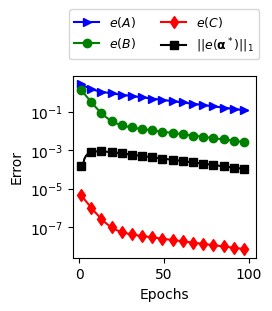

In [182]:
problem = "Kuramoto_Sivashinsky_noise"
noise = 0.0/100. # added noise as standard deviation of the normal distribution
fs = fs0.copy()
fs = fs*(1+np.random.normal(0.0, noise, fs.shape) )

tol = 1e-10
start_time = time.time()
numPDE = fs.shape[0]

V = L
ds = np.array([[1], [2], [3], [4]])
ps = np.array([[1], [2]])
D = np.max(np.sum(ds,axis=1))
P = np.max(np.sum(ps,axis=1))

params = np.zeros((numPDE,len(ds),len(ps)))
beta = 50.
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) )
epochs = 100
estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

params0 = params
for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2,:]
        ft0 = fst[:, 0,:]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params
    if np.linalg.norm(params-params0) < tol:
        epochs = ep
        break
    params0 = params

eps = [i for i in range(epochs)]

estimated_params = estimated_params[:epochs,:] 

i_pde = 0

error = 0.

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            error += abs( estimated_params[-1,i_pde,id,ip]-A_ex )
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker=">", markevery=6)

for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            error += abs( estimated_params[-1,i_pde,id,ip]-B_ex )
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="green", marker="o", markevery=6)
            
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==4 and p[0]==1:
            error += abs( estimated_params[-1,i_pde,id,ip]-C_ex )
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="red", marker="d", markevery=6)

plt.axhline(A_ex, color="blue", linestyle = "--", label=r"$A$")
plt.axhline(B_ex, color="green", linestyle = "--", label=r"$B$")
plt.axhline(C_ex, color="red", linestyle = "--", label=r"$C$")
plt.ylabel('Coefficient')
plt.xlabel('Epochs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=9)
name = problem + "_" + "coeffconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (  (d[0]==4 and p[0]==1) or
                  (d[0]==2 and p[0]==1) or
                  (d[0]==1 and p[0]==2)    ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1


## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker=">", markevery=6, color="blue")
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-B_ex),
                     label=r"$e(B)$", marker="o", markevery=6, color="green")
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==4 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-C_ex),
                     label=r"$e(C)$", marker="d", markevery=6, color="red")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=6, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=9)
name = problem + "_" + "coeff"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

error += err_other[-1]

print(error)

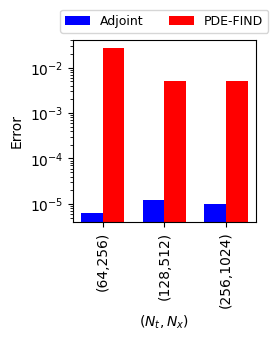

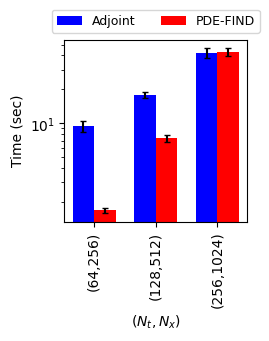

In [196]:
err_adjoint = np.array([6.2e-06,  1.2e-05,  1.e-05  ])
err_pdefind = np.array([0.027 ,   0.0050,  0.0051])

t_adjoint = np.array([9.47,  17.9 ,  42.3 ])
t_pdefind = np.array([1.691 ,  7.381,  42.9])
t_adjoint_bars = np.array([1.1,  1.2 ,  4.3 ])
t_pdefind_bars = np.array([0.1,  0.5 ,  3.3 ])

discr_ = ['(64,256)', '(128,512)', '(256,1024)']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "Kuramoto_Sivashinsky_err_grid"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, t_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint", yerr=t_adjoint_bars)
plt.bar(bar_positions2, t_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND", yerr=t_pdefind_bars)
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Time (sec)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "Kuramoto_Sivashinsky_time_grid"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)


### FIND-PDE

In [157]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

'''
Ut, R, rhs_des = build_linear_system(fs[0], dt, dx[0], D=3, P=3, time_diff = 'FD', space_diff = 'FD')
print(['1'] + rhs_des[1:])
w = TrainSTRidge(R, Ut, 10**1, 0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)
'''

import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))
uxxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3
    uxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0) / dx[0]**4

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))
uxxxx = uxxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx, uxxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}', 'u_{xxxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['u'])
print(['1'] + description[1:])

c = TrainSTRidge(X,ut,10**-6,1)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( abs(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )
print(np.sum(coeff_pdefind[1:]))

print(coeff_pdefind)
error = abs(coeff_pdefind[0][0]-B_ex)
error += abs(-coeff_pdefind[1][0]-C_ex)
error += abs(-coeff_pdefind[3][0]-2*A_ex)
print("error: "+str(error))

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u_{xxxx}', 'u', 'u^2', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}', 'uu_{xxx}', 'u^2u_{xxx}', 'uu_{xxxx}', 'u^2u_{xxxx}']
u_t = (-0.500007 +0.000000i)u_{xx}
    + (0.500000 +0.000000i)u_{xxxx}
    + (-0.009773 +0.000000i)u
    + (2.005361 +0.000000i)uu_{x}
    + (0.000285 +0.000000i)u^2u_{x}
    + (-0.000051 +0.000000i)uu_{xx}
    + (0.001167 +0.000000i)u^2u_{xx}
    + (0.000061 +0.000000i)uu_{xxx}
    + (0.000004 +0.000000i)u^2u_{xxx}
    + (-0.000001 +0.000000i)uu_{xxxx}
    + (0.000016 +0.000000i)u^2u_{xxxx}
   
Execution time: 42.92624092102051
2.516718652173045
[[5.00006625e-01]
 [5.00000001e-01]
 [9.77312079e-03]
 [2.00536054e+00]
 [2.85078453e-04]
 [5.09417153e-05]
 [1.16724535e-03]
 [6.14144751e-05]
 [4.07219813e-06]
 [7.41768032e-07]
 [1.55013116e-05]]
error: 0.005367161503143758


In [145]:
error = abs(coeff_pdefind[0][0]-B_ex)
error += abs(-coeff_pdefind[1][0]-C_ex)
error += abs(-coeff_pdefind[3][0]-2*A_ex)
print(error)

0.005177224381812839


In [34]:
data = sio.loadmat('PDE-FIND//Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]
n = len(x)
m = len(t)
print(n)
print(m)

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=5, P=5, time_diff = 'FD', space_diff = 'FD')

w = TrainSTRidge(R,Ut,10**-5,5)
print("PDE derived using STRidge")
print_pde(w, rhs_des)


1024
251
PDE derived using STRidge
u_t = (-0.984053 +0.000000i)uu_{x}
    + (-0.993750 +0.000000i)u_{xx}
    + (-0.998328 +0.000000i)u_{xxxx}
   


In [178]:
data = sio.loadmat('PDE-FIND//Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]

print(dt/dx**4)

fs = np.array([u.T])
print(fs.shape)

dx = np.array([dx])
x = np.array([x])

tol = 1e-6
start_time = time.time()
numPDE = fs.shape[0]

V = L
ds = np.array([[1], [2], [3], [4]])
ps = np.array([[1], [2]])
D = np.max(np.sum(ds,axis=1))
P = np.max(np.sum(ps,axis=1))

params = np.zeros((numPDE,len(ds),len(ps)))
beta = 0.00001
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) )
epochs = 200
estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

params0 = params
for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2,:]
        ft0 = fst[:, 0,:]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params
    if np.linalg.norm(params-params0) < tol:
        epochs = ep
        break
    params0 = params

eps = [i for i in range(epochs)]

estimated_params = estimated_params[:epochs,:] 

for i_pde in range(numPDE): 
    plt.figure(figsize=(size*cm, size*cm))
    for id in range(len(ds)):
        for ip in range(len(ps)):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{"+str(i_pde)+","+str(id)+","+str(ip)+"}$")
    #for j in range(len(coef[i_pde,:])):
    #    plt.axhline(coef[i_pde,j], linestyle = "--")
    plt.axhline(0,    color="grey", linestyle = "-.")
    plt.xlabel('Epochs')
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (  (d[0]==4 and p[0]==1) or
                  (d[0]==2 and p[0]==1) or
                  (d[0]==1 and p[0]==2)    ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

problem = "1D_heat_equation"
## coeff of u
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==4 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker=">", markevery=4, color="blue")
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-D_ex),
                     label=r"$e(D)$", marker="d", markevery=4, color="red")
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-B_ex),
                     label=r"$e(B)$", marker="o", markevery=4, color="green")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=4, color="black", label=r"$|e(\mathbf{\alpha}^*)|_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "D"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(2*len(ds)*len(ps)))

4305.8650434751535
(1, 251, 1024)


KeyboardInterrupt: 

## Reaction Diffusion Equation

In [3]:
## 2D, 2PDE Reaction_diffusion_equation

# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0

Nx0 = 100  # Number of grid points in x-direction
Nx1 = 100  # Number of grid points in y-direction
Lx0 = 1.0  # Domain size in x-direction
Lx1 = 1.0  # Domain size in y-direction
V = Lx0*Lx1
dt = 0.000001  # Time step size
Nt = 200

# Discretize the spatial domain
x0 = np.linspace(0, Lx0, Nx0)
x1 = np.linspace(0, Lx1, Nx1)
x = np.array([x0, x1])
dx0 = x0[1] - x0[0]
dx1 = x1[1] - x1[0]
X0, X1 = np.meshgrid(x0, x1)
dx = np.array([dx0, dx1])

# Set initial conditions
f0 = np.array([np.sin(4*np.pi*X0/Lx0) * np.cos(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100,
               np.cos(4*np.pi*X0/Lx0) * np.sin(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100])

def Reaction_diffusion_equation(coefu, coefv, u0_m, v0_m, dx_m, dy_m, dt_m, Nt_m):
    u_m = np.zeros((Nt_m, u0_m.shape[0], u0_m.shape[1]))# (Nt, Nx, Ny)
    v_m = np.zeros((Nt_m, v0_m.shape[0], v0_m.shape[1]))#
    u_m[0,:,:] = u0_m
    v_m[0,:,:] = v0_m
    for i in range(Nt_m-1):
        u_m[i+1,:,:] =  u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[0] * np.gradient( np.gradient(u_m[i,:,:],axis=0), axis=0) / dx_m**2 
        u_m[i+1,:,:] += - dt_m*coefu[1] * np.gradient( np.gradient(u_m[i,:,:],axis=1), axis=1) / dy_m**2
        u_m[i+1,:,:] += - dt_m*coefu[2] * u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[3] * u_m[i,:,:]**3
        u_m[i+1,:,:] += - dt_m*coefu[4] * u_m[i,:,:]    * v_m[i,:,:]**2
        u_m[i+1,:,:] += - dt_m*coefu[5] * u_m[i,:,:]**2 * v_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coefu[6] * v_m[i,:,:]**3
        
        v_m[i+1,:,:] =  v_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[0] * np.gradient( np.gradient(v_m[i,:,:],axis=0), axis=0) / dx_m**2 
        v_m[i+1,:,:] += - dt_m*coefv[1] * np.gradient( np.gradient(v_m[i,:,:],axis=1), axis=1) / dy_m**2
        v_m[i+1,:,:] += - dt_m*coefv[2] * v_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[3] * v_m[i,:,:]**3
        v_m[i+1,:,:] += - dt_m*coefv[4] * v_m[i,:,:]    * u_m[i,:,:]**2
        v_m[i+1,:,:] += - dt_m*coefv[5] * v_m[i,:,:]**2 * u_m[i,:,:]
        v_m[i+1,:,:] += - dt_m*coefv[6] * u_m[i,:,:]**3
    return u_m, v_m

coefu = [-0.1, -0.2, -0.3, -0.4, 0.1, 0.2, 0.3]
coefv = [-0.4, -0.3, -0.2, -0.1, 0.3, 0.2, 0.1]
coef = np.array([coefu, coefv])
# Generate data
fs0, fs1 = Reaction_diffusion_equation(coefu, coefv, f0[0,:], f0[1,:], dx0, dx1, dt, Nt)
fs = np.array([fs0, fs1])

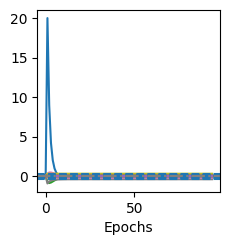

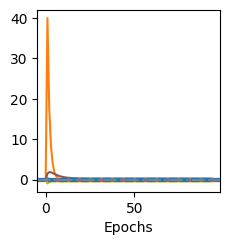

Execution time: 1000.8232860565186


In [14]:
start_time = time.time()
numPDE = fs.shape[0]
tol = 1e-10

#dim = 2
#D = 2
#P = 3
#ds = generate_combinations(dim, D)
#ps = generate_combinations(numPDE, P)
#ps = [sublist for sublist in ps if sublist != [0, 0]] # remove (0,0)

ds = np.array([[0,0], [1,0], [0,1], [2,0], [0,2]])
ps = np.array([[1,0], [0,1], [1,1], [2,0], [0,2], [2,1], [1,2], [3,0], [0,3]])
D = np.max(np.sum(ds,axis=1))
P = np.max(np.sum(ps,axis=1))

params = np.zeros((numPDE,len(ds),len(ps)))

beta = 0.002
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) ) *10**(P-sum(p))
        if sum(d) == 0:
            learning_rates[:,i,j] *= 40
#learning_rates[:,0,:] *= 40

epochs = 1000
estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

params0 = params

for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2,:]
        ft0 = fst[:, 0,:]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params
    if np.linalg.norm(params-params0) < tol:
        epochs = ep
        break
    params0 = params

eps = [i for i in range(epochs)]
estimated_params = estimated_params[:epochs,:] 

for i_pde in range(numPDE): 
    plt.figure(figsize=(size*cm, size*cm))
    for id in range(len(ds)):
        for ip in range(len(ps)):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{"+str(i_pde)+","+str(id)+","+str(ip)+"}$")
    for j in range(len(coef[i_pde,:])):
        plt.axhline(coef[i_pde,j], linestyle = "--")
    plt.axhline(0,    color="grey", linestyle = "-.")
    plt.xlabel('Epochs')
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))


total number of terms: 90
6.696056857325617e-10


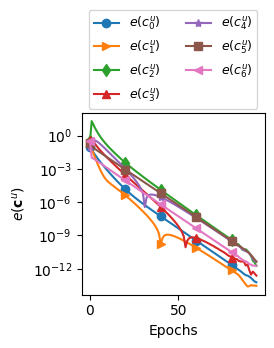

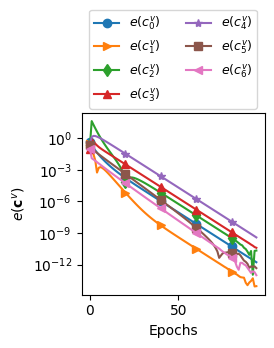

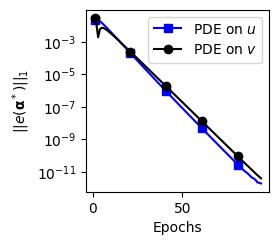

In [15]:
# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0
problem = "2D_reaction"
## coeff of u
totalerror = 0
i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[0]),#/abs(coefu[0]),
                     label=r"$e(c^u_0)$", marker="o", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[0])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[1]==2 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[1]),#/abs(coefu[1]),
                     label=r"$e(c^u_1)$", marker=">", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[1])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[2]),#/abs(coefu[2]),
                     label=r"$e(c^u_2)$", marker="d", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[2])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[3]),#/abs(coefu[3]),
                     label=r"$e(c^u_3)$", marker="^", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[3])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[4]),#/abs(coefu[4]),
                     label=r"$e(c^u_4)$", marker="*", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[4])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[5]),#/abs(coefu[5]),
                     label=r"$e(c^u_5)$", marker="s", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[5])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefu[6]),#/abs(coefu[6]),
                     label=r"$e(c^u_6)$", marker="<", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefu[6])
plt.yscale('log')
plt.ylabel(r'$e(\mathbf{c}^u)$')
plt.xlabel('Epochs')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2, fontsize=9)
name = problem + "_" + "c_u"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## other coeff of u
i_pde = 0


err_otheru = np.zeros_like(estimated_params[:,0,0,0])
countu = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (   (d[0]==2 and p[0]==1 and p[1]==0)
                or (d[1]==2 and p[0]==1 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2)
                or (d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3) ) :
                    err_otheru += abs(estimated_params[:,i_pde,id,ip])
                    countu += 1

## coeff of v
i_pde = 1
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[0]),#/abs(coefv[0]),
                     label=r"$e(c^v_0)$", marker="o", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[0])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[1]==2 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[1]),#/abs(coefv[1]),
                     label=r"$e(c^v_1)$", marker=">", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[1])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[2]),#/abs(coefv[2]),
                     label=r"$e(c^v_2)$", marker="d", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[2])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[3]),#/abs(coefv[3]),
                     label=r"$e(c^v_3)$", marker="^", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[3])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[4]),#/abs(coefv[4]),
                     label=r"$e(c^v_4)$", marker="*", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[4])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[5]),#/abs(coefv[5]),
                     label=r"$e(c^v_5)$", marker="s", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[5])
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0:
            plt.plot(abs(estimated_params[:,i_pde,id,ip]-coefv[6]),#/abs(coefv[6]),
                     label=r"$e(c^v_6)$", marker="<", markevery=20)
            totalerror += abs(estimated_params[-1,i_pde,id,ip]-coefv[6])
plt.yscale('log')
plt.ylabel(r'$e(\mathbf{c}^v)$')
plt.xlabel('Epochs')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2, fontsize=9)
name = problem + "_" + "c_v"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

err_otherv = np.zeros_like(estimated_params[:,1,0,0])
countv = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (   (d[0]==2 and p[0]==0 and p[1]==1)
                or (d[1]==2 and p[0]==0 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==0 and p[1]==3)
                or (d[0]==0 and d[1]==0 and p[0]==2 and p[1]==1)
                or (d[0]==0 and d[1]==0 and p[0]==1 and p[1]==2)
                or (d[0]==0 and d[1]==0 and p[0]==3 and p[1]==0) ) :
                    err_otherv += abs(estimated_params[:,i_pde,id,ip])
                    countv += 1
            

plt.figure(figsize=(size*cm, size*cm))

plt.plot(eps[1:], err_otheru[1:]/countu, marker="s", markevery=20, label=r"PDE on $u$", color="blue")
plt.plot(eps[1:], err_otherv[1:]/countv, marker="o", markevery=20, label=r"PDE on $v$", color="black")
plt.legend()
plt.yscale('log')
plt.ylabel(r'$||e(\mathbf{\alpha}^*)||_1$')
plt.xlabel('Epochs')
name = problem + "_" + "other_alphas"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(numPDE*len(ds)*len(ps)))

totalerror += err_otheru[-1]
totalerror += err_otherv[-1]
print(totalerror)

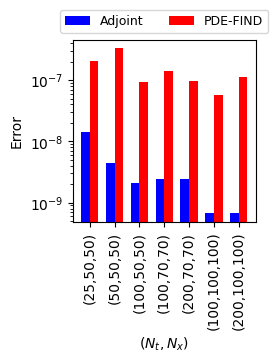

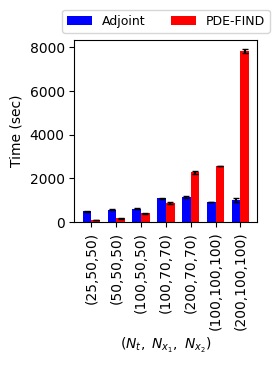

In [19]:
problem = "2D_reaction"

discr     = np.array( [25*50**2, 50*50**2, 100*50**2, 100*70**2, 200*70**2,   100*100**2, 200*100**2] )

err_adjoint = np.array([1.4e-8,   4.48e-09,  2.11e-09, 2.43e-09, 2.433e-09 , 6.696e-10, 6.6960e-10 ])
err_pdefind = np.array([2.06e-07, 3.34e-07,  9.31e-08, 1.43e-07, 9.758e-08, 5.758e-08, 1.1241e-07])

t_adjoint = np.array( [477.6,   566.5,      599.4,     1086.3,     1144.8,       895.5,  1000.5   ])
t_pdefind = np.array( [80.1,    169.0,       386,      869,        2267.4,       2561.76, 7846.3  ])
t_adjoint_bars = np.array([10.,    20,       20,         20,          30,     1,   100])
t_pdefind_bars = np.array([10.,    20,       30,         40,          50,     1,   100])

discr_ = ['(25,50,50)', '(50,50,50)', '(100,50,50)', '(100,70,70)', '(200,70,70)', '(100,100,100)', '(200,100,100)']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x)$')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = problem+"_err_grid"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)


plt.figure(figsize=(size*cm, size*cm))
# Sample data

# Plotting the bar chart
bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.bar(bar_positions1, t_adjoint[:len(discr_)], color='blue', width=bar_width, yerr=t_adjoint_bars, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, t_pdefind[:len(discr_)], color='red', width=bar_width, yerr=t_pdefind_bars, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
plt.xlabel(r'$(N_t,\ N_{x_1},\ N_{x_2})$')
plt.ylabel('Time (sec)')
# Display the plot

name = problem + "_extime_pdefind"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

plt.show()



### Using FIND-PDE

In [4]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1
num_points = Nx0*Nx1*nt

print(nt)
print(Nx0)
# Take up to second order derivatives.
u = np.zeros((nt, Nx0, Nx1))
v = np.zeros((nt, Nx0, Nx1))
ut = np.zeros((nt, Nx0, Nx1))
vt = np.zeros((nt, Nx0, Nx1))
ux = np.zeros((nt, Nx0, Nx1))
uy = np.zeros((nt, Nx0, Nx1))
uxx = np.zeros((nt, Nx0, Nx1))
uxy = np.zeros((nt, Nx0, Nx1))
uyy = np.zeros((nt, Nx0, Nx1))
vx = np.zeros((nt, Nx0, Nx1))
vy = np.zeros((nt, Nx0, Nx1))
vxx = np.zeros((nt, Nx0, Nx1))
vxy = np.zeros((nt, Nx0, Nx1))
vyy = np.zeros((nt, Nx0, Nx1))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    v[i,:] = fs[1, i, :]

    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    vt[i,:] = (fs[1, i+1, :]-fs[1, i, :])/dt
    
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uy[i,:] = np.gradient(u[i,:], axis=1) / dx[1]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uyy[i,:] = np.gradient( np.gradient(u[i,:],axis=1), axis=1) / dx[1]**2
    uxy[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=1) / dx[0]/ dx[1]

    vx[i,:] = np.gradient(v[i,:], axis=0) / dx[0]
    vy[i,:] = np.gradient(v[i,:], axis=1) / dx[1]
    vxx[i,:] = np.gradient( np.gradient(v[i,:],axis=0), axis=0) / dx[0]**2
    vyy[i,:] = np.gradient( np.gradient(v[i,:],axis=1), axis=1) / dx[1]**2
    vxy[i,:] = np.gradient( np.gradient(v[i,:],axis=0), axis=1) / dx[0]/ dx[1]

u = u.reshape((nt * Nx0 * Nx1, 1))
v = v.reshape((nt * Nx0 * Nx1, 1))

ut = ut.reshape((nt * Nx0 * Nx1, 1))
vt = vt.reshape((nt * Nx0 * Nx1, 1))

ux = ux.reshape((nt * Nx0 * Nx1, 1))
uy = uy.reshape((nt * Nx0 * Nx1, 1))
uxx = uxx.reshape((nt * Nx0 * Nx1, 1))
uyy = uyy.reshape((nt * Nx0 * Nx1, 1))
uxy = uxy.reshape((nt * Nx0 * Nx1, 1))

vx = vx.reshape((nt * Nx0 * Nx1, 1))
vy = vy.reshape((nt * Nx0 * Nx1, 1))
vxx = vxx.reshape((nt * Nx0 * Nx1, 1))
vyy = vyy.reshape((nt * Nx0 * Nx1, 1))
vxy = vxy.reshape((nt * Nx0 * Nx1, 1))

X_data = np.hstack([u,v])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders_descr = ['','u_{x}', 'u_{y}','u_{xx}','u_{xy}','u_{yy}','v_{x}', 'v_{y}','v_{xx}','v_{xy}','v_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 3, data_description = ['u','v'])
print(['1'] + description[1:])

print("time: "+str(time.time()-start_time))

cu = TrainSTRidge(X,ut,5*10**-5,1)
print_pde(cu, description)

print("time: "+str(time.time()-start_time))

cv = TrainSTRidge(X,vt,5*10**-5,1)
print_pde(cv, description, ut = 'v_t')

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

199
100
['1', 'u_{x}', 'u_{y}', 'u_{xx}', 'u_{xy}', 'u_{yy}', 'v_{x}', 'v_{y}', 'v_{xx}', 'v_{xy}', 'v_{yy}', 'v', 'u', 'v^2', 'uv', 'u^2', 'v^3', 'uv^2', 'u^2v', 'u^3', 'vu_{x}', 'uu_{x}', 'v^2u_{x}', 'uvu_{x}', 'u^2u_{x}', 'v^3u_{x}', 'uv^2u_{x}', 'u^2vu_{x}', 'u^3u_{x}', 'vu_{y}', 'uu_{y}', 'v^2u_{y}', 'uvu_{y}', 'u^2u_{y}', 'v^3u_{y}', 'uv^2u_{y}', 'u^2vu_{y}', 'u^3u_{y}', 'vu_{xx}', 'uu_{xx}', 'v^2u_{xx}', 'uvu_{xx}', 'u^2u_{xx}', 'v^3u_{xx}', 'uv^2u_{xx}', 'u^2vu_{xx}', 'u^3u_{xx}', 'vu_{xy}', 'uu_{xy}', 'v^2u_{xy}', 'uvu_{xy}', 'u^2u_{xy}', 'v^3u_{xy}', 'uv^2u_{xy}', 'u^2vu_{xy}', 'u^3u_{xy}', 'vu_{yy}', 'uu_{yy}', 'v^2u_{yy}', 'uvu_{yy}', 'u^2u_{yy}', 'v^3u_{yy}', 'uv^2u_{yy}', 'u^2vu_{yy}', 'u^3u_{yy}', 'vv_{x}', 'uv_{x}', 'v^2v_{x}', 'uvv_{x}', 'u^2v_{x}', 'v^3v_{x}', 'uv^2v_{x}', 'u^2vv_{x}', 'u^3v_{x}', 'vv_{y}', 'uv_{y}', 'v^2v_{y}', 'uvv_{y}', 'u^2v_{y}', 'v^3v_{y}', 'uv^2v_{y}', 'u^2vv_{y}', 'u^3v_{y}', 'vv_{xx}', 'uv_{xx}', 'v^2v_{xx}', 'uvv_{xx}', 'u^2v_{xx}', 'v^3v_{x

In [8]:
# u_t + cu0 * u_xx + cu1 * u_yy + cu2 * u + cu3 * u^3 + cu4 * u*v^2 + cu5 * u^2*v + cu6 * v^3 = 0
# v_t + cv0 * v_xx + cv1 * v_yy + cv2 * v + cv3 * v^3 + cv4 * v*u^2 + cv5 * v^2*u + cv6 * u^3 = 0

print("Coeffs of u:")
err = 0
cu_ = abs(cu)[:,0]
for i in range(len(cu_)):
    if description[i] == 'u_{xx}':
        print(description[i])
        err += abs( -cu_[i]-coefu[0] )
    elif description[i] == 'u_{yy}':
        print(description[i])
        err += abs( -cu_[i]-coefu[1] )
    elif description[i] == 'u':
        print(description[i])
        err += abs( -cu_[i]-coefu[2] )
    elif description[i] == 'u^3':
        print(description[i])
        err += abs( -cu_[i]-coefu[3] )
    elif description[i] == 'uv^2':
        print(description[i])
        err += abs( cu_[i]-coefu[4] )
    elif description[i] == 'u^2v':
        print(description[i])
        err += abs( cu_[i]-coefu[5] )
    elif description[i] == 'v^3':
        print(description[i])
        err += abs( cu_[i]-coefu[6] )
    else:
        err += abs( cu_[i] )

print("Coeffs of v:")
cv_ = abs(cv)[:,0]
for i in range(len(cv_)):
    if description[i] == 'v_{xx}':
        print(description[i])
        err += abs( -cv_[i]-coefv[0] )
    elif description[i] == 'v_{yy}':
        print(description[i])
        err += abs( -cv_[i]-coefv[1] )
    elif description[i] == 'v':
        print(description[i])
        err += abs( -cv_[i]-coefv[2] )
    elif description[i] == 'v^3':
        print(description[i])
        err += abs( -cv_[i]-coefv[3] )
    elif description[i] == 'u^2v':
        print(description[i])
        err += abs( cv_[i]-coefv[4] )
    elif description[i] == 'uv^2':
        print(description[i])
        err += abs( cv_[i]-coefv[5] )
    elif description[i] == 'u^3':
        print(description[i])
        err += abs( cv_[i]-coefv[6] )
    else:
        err += abs( cv_[i] )
        
print(err)

Coeffs of u:
u_{xx}
u_{yy}
u
v^3
uv^2
u^2v
u^3
Coeffs of v:
v_{xx}
v_{yy}
v
v^3
uv^2
u^2v
u^3
1.1241204603329317e-07


In [5]:
coeff_pdefind = []
for i in range(len(cu)):
        if cu[i] != 0:
            coeff_pdefind.append( abs(cu[i]) )
coeff_pdefind = np.array( coeff_pdefind )[:,0]

print(coeff_pdefind.T)
error = abs(coeff_pdefind[0])
error += abs( coefu[0] + coeff_pdefind[1] )
error += abs( coefu[1] + coeff_pdefind[2] )
error += abs( coefu[2] + coeff_pdefind[3] )
error += abs(coeff_pdefind[4])
error += abs( coefu[3] + coeff_pdefind[5] )
error += abs( coefu[4] - coeff_pdefind[7] )
error += abs( coefu[5] - coeff_pdefind[6] )
error += abs( coefu[6] - coeff_pdefind[8] )
for i in range(9, len(coefu)):
    error += abs(coefu[i])


coeff_pdefind = []
for i in range(len(cu)):
        if cv[i] != 0:
            coeff_pdefind.append( abs(cv[i]) )
coeff_pdefind = np.array( coeff_pdefind )[:,0]

print(coeff_pdefind.T)
error = abs(coeff_pdefind[0])
error += abs( coefv[0] + coeff_pdefind[1] )
error += abs( coefv[1] + coeff_pdefind[2] )
error += abs( coefv[2] + coeff_pdefind[3] )
error += abs(coeff_pdefind[4])
error += abs( coefv[3] + coeff_pdefind[5] )
error += abs( coefv[4] - coeff_pdefind[7] )
error += abs( coefv[5] - coeff_pdefind[6] )
error += abs( coefv[6] - coeff_pdefind[8] )
for i in range(9, len(coefv)):
    error += abs(coefv[i])
    
print(error)

NameError: name 'cu' is not defined

In [125]:
print_pde(c, description, ut = 'v_t')

v_t = (0.001179 +0.000000i)u_{xy}
    + (0.398718 +0.000000i)v_{xx}
    + (0.299066 +0.000000i)v_{yy}
    + (-0.009701 +0.000000i)v^2
    + (-0.005672 +0.000000i)u^2
    + (0.127738 +0.000000i)v^3
    + (-0.200073 +0.000000i)uv^2
    + (-0.297973 +0.000000i)u^2v
    + (-0.099921 +0.000000i)u^3
    + (-0.000028 +0.000000i)uu_{xx}
    + (-0.000718 +0.000000i)uvu_{xx}
    + (0.000003 +0.000000i)u^2u_{xx}
    + (-0.000781 +0.000000i)uv^2u_{xx}
    + (-0.000014 +0.000000i)u^3u_{xx}
    + (-0.000091 +0.000000i)vu_{xy}
    + (0.000098 +0.000000i)v^2u_{xy}
    + (-0.000347 +0.000000i)u^2u_{xy}
    + (-0.000125 +0.000000i)v^3u_{xy}
    + (0.000118 +0.000000i)u^2vu_{xy}
    + (-0.000001 +0.000000i)u^3u_{xy}
    + (-0.000430 +0.000000i)uvu_{yy}
    + (0.000002 +0.000000i)u^2u_{yy}
    + (-0.000430 +0.000000i)uv^2u_{yy}
    + (0.000163 +0.000000i)vv_{xx}
    + (0.000274 +0.000000i)u^2v_{xx}
    + (0.000068 +0.000000i)v^3v_{xx}
    + (-0.000049 +0.000000i)u^2vv_{xx}
    + (0.000001 +0.000000i)u^3v_

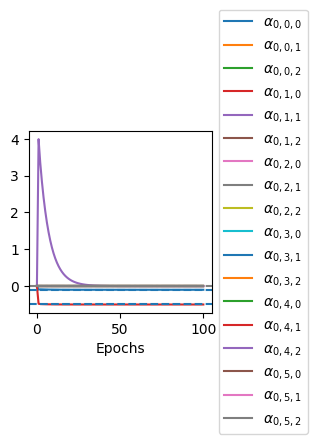

rel error target terms
rel err c_0 = 1.0640008318851812e-08
rel err c_1 = 2.0532406885820365e-09
error in other terms (should be excluded)
3.234629600067481e-14
3.668176896164535e-14
5.79890409991929e-14
1.643091969683824e-13
3.000490982218115e-07
8.451525799753895e-13
0.00012940773081713075
6.577437849129912e-16
3.236985297933682e-14
5.012748856810828e-12
3.5446799353679553e-16
3.362046676010723e-12
3.4922974558547955e-16
1.2170285873304717e-12
2.6509259601984247e-14
3.950302193278773e-14


In [300]:
## 2D Laplace equation

Nx0 = 50  # Number of grid points in x-direction
Nx1 = 50  # Number of grid points in y-direction
Lx0 = 1.0  # Domain size in x-direction
Lx1 = 1.0  # Domain size in y-direction
Nt = 20
V = Lx0*Lx1

# Discretize the spatial domain
x0 = np.linspace(0, Lx0, Nx0)
x1 = np.linspace(0, Lx1, Nx1)
dx0 = x0[1] - x0[0]
dx1 = x1[1] - x1[0]
X0, X1 = np.meshgrid(x0, x1)

# Set initial conditions
f0 = np.sin(4*np.pi*X0/Lx0) * np.cos(3*np.pi * X1 / Lx1) * X0 * (Lx0-X0) * X1 * (Lx1-X1) * 100

## df/dt + c0 * nabla^2_x0 f + c1 * nabla^2_x1 f = 0
def Diffusion_equation(coef, u0_m, dx_m, dy_m, dt_m, Nt_m):
    u_m = np.zeros((Nt_m, u0_m.shape[0], u0_m.shape[1]))# (Nt, Nx, Ny)
    u_m[0,:,:] = u0_m
    for i in range(Nt_m-1):
        u_m[i+1,:,:] =  u_m[i,:,:]
        u_m[i+1,:,:] += - dt_m*coef[0] * np.gradient( np.gradient(u_m[i,:,:],axis=0), axis=0) / dx_m**2 
        u_m[i+1,:,:] += - dt_m*coef[1] * np.gradient( np.gradient(u_m[i,:,:],axis=1), axis=1) / dy_m**2
    return u_m

c = np.array([-0.1, -0.5])

x = np.array([x0, x1])
dx = np.array([dx0, dx1])
CFL = 0.01
dt = CFL*np.min(dx)**2/np.max(abs(c))

# Generate data
fs = np.array([Diffusion_equation(c, f0, dx0, dx1, dt, Nt)])

dim = 2
D = 2
P = 2
numPDE = 1
ds = generate_combinations(dim, D)
ps = generate_combinations(numPDE, P)

beta = 0.08
params = np.zeros((numPDE,len(ds),len(ps)))

learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) ) *10**(P-sum(p))
        
epochs = 100
estimated_params = np.zeros((epochs+1,numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2, :]
        ft0 = fst[:, 0, :]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params

for i_pde in range(numPDE): 
    plt.figure(figsize=(size*cm, size*cm))
    for id in range(len(ds)):
        for ip in range(len(ps)):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{"+str(i_pde)+","+str(id)+","+str(ip)+"}$")
    for j in range(len(c)):
        plt.axhline(c[j], linestyle = "--")
    plt.axhline(0,    color="grey", linestyle = "-.")
    plt.xlabel('Epochs')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #name = "Laplace"
    #plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
    #plt.ylim([-1,1])
    #plt.xlim([50,100])
    #plt.xscale('log')
plt.show()

print("rel error target terms")
for id, d in enumerate(ds):
    for i_p, p in enumerate(ps):
            if (p[0]==1 and d[0]==2 and d[1]==0):
                print("rel err c_0 = " + str(abs( (params[i_pde, id, i_p] - c[0]) / c[0] )))
            if (p[0]==1 and d[0]==0 and d[1]==2):
                print("rel err c_1 = " + str(abs( (params[i_pde, id, i_p] - c[1]) / c[1] )))
print("error in other terms (should be excluded)")
for id, d in enumerate(ds):
    for i_p, p in enumerate(ps):
            if not ( (p[0]==1 and d[0]==2 and d[1]==0) or (p[0]==1 and d[0]==0 and d[1]==2) ):
                print(str(abs( (params[i_pde, id, i_p]))) )


## Random Walk

cfl 1.6172580808407135


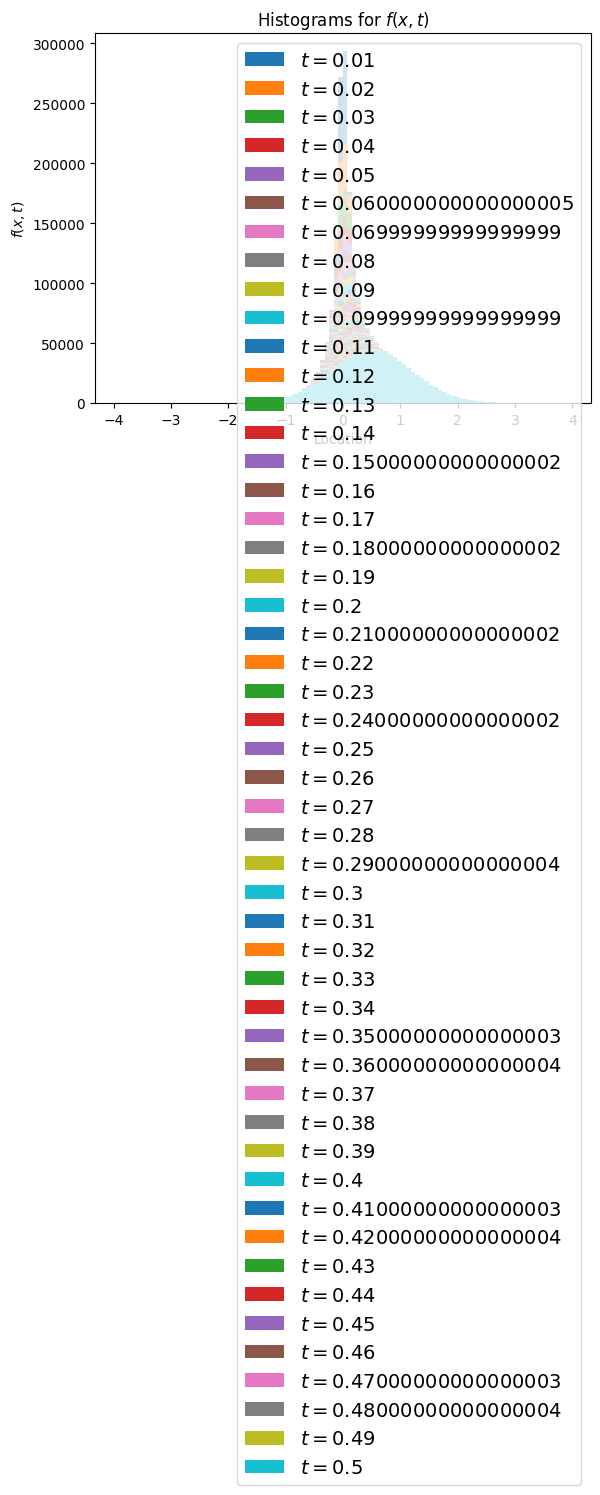

In [3]:
Ns = 10000
m = 50
n = 100
length = n*Ns
dt = 0.01
c = 1.

P = {}
M = 0

np.random.seed(0)
pos = np.cumsum(np.sqrt(dt)*np.random.randn(length)) + c*dt*np.arange(length)



for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
    
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
    
bins = np.linspace(-M,M,n+1)
x = np.linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = np.linspace(0,dt*(m-1),m)
U = np.zeros((n,m))
for i in range(m):
    U[:,i] = plt.hist(P[i],bins,label=r'$t = $' + str(i*dt+dt))[0]/float(dx*(len(pos)-m))

print("cfl "+str(dt/dx**2))

plt.xlabel('Location')
plt.ylabel(r'$f(x,t)$')
plt.title(r'Histograms for $f(x,t)$')
plt.legend(loc = 'upper right', fontsize = 14)

Nt = U.shape[1]
Nx = U.shape[0]
L = x[-1]-x[0]
fs = U.T

fs = np.array([fs])
dx = np.array([dx])
x = np.array([x])

In [226]:
c

array([[ 0.        +0.j],
       [-1.02401768+0.j],
       [ 0.4551503 +0.j],
       [-0.00395114+0.j]])

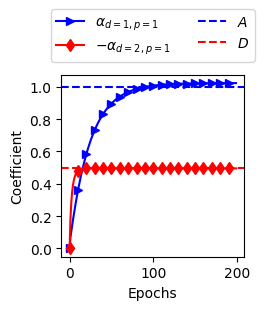

Execution time: 7.564342975616455
1.0221781411951714
total number of terms: 3
[[[ 1.02279019]
  [-0.49511109]
  [ 0.00428777]]]


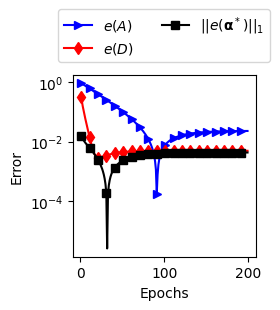

In [4]:
problem = "RandomWalk"
tol = 1e-6
start_time = time.time()
numPDE = fs.shape[0]

A_ex = 1.0
D_ex = 0.5

V = L
ds = np.array([[1], [2], [3]])
ps = np.array([[1]])
D = np.max(np.sum(ds,axis=1))
P = np.max(np.sum(ps,axis=1))

params = np.zeros((numPDE,len(ds),len(ps)))
beta = 0.001
learning_rates = np.ones((numPDE, len(ds),len(ps)))
for i, d in enumerate(ds):
    for j, p in enumerate(ps):
        learning_rates[:,i,j] = beta * ( min(dx)**(sum(d)-D) ) #* 0.01**p
epochs = 200
estimated_params = np.zeros((epochs+1, numPDE, len(ds),len(ps)))
estimated_params[0,:] = params

params0 = params
for ep in range(1, epochs+1):
    for i in range(Nt-1):
        fst = fs[:, i:i+2,:]
        ft0 = fst[:, 0,:]

        ft  = forward_m(params, ps, ds, ft0, dx, dt, 2)
        lam = adjoint_eq(params, ps, ds, fst, ft, dx, dt, 2)

        dC_dparams = np.zeros((numPDE, len(ds),len(ps)))
        for i_pde in range(numPDE):
            for i_d, d in enumerate(ds):
                temp = np.array([lam[i_pde, ii,:] for ii in range(2)])
                for i_di, di in enumerate(d):
                    for rep in range(1, di+1):
                        temp = np.array([np.gradient(temp[ii,:], axis=i_di) for ii in range(2)] ) / dx[i_di]
                temp *= (-1)**sum(d)
                for i_p, p in enumerate(ps):
                    tempf = np.ones_like(ft[0,:]) # (Nt, Nx0, Nx1,...)
                    for i_pi, pi in enumerate(p):
                        tempf *= ft[i_pi, :]**pi
                    integ = np.array( [ tempf[ii,:] * temp[ii,:] for ii in range(2)] )
                    for xi in range(len(dx)-1, -1, -1):
                        integ = np.array( [integrate.trapezoid(integ[ii,:], x[xi], axis=xi) for ii in range(2)] )
                    dC_dparams[i_pde, i_d, i_p] = np.sum(integ) * dt / (2*dt) / V
        params = params - dC_dparams * learning_rates
    estimated_params[ep,:] = params
    if np.linalg.norm(params-params0) < tol:
        epochs = ep
        break
    params0 = params

eps = [i for i in range(epochs)]

estimated_params = estimated_params[:epochs,:] 

i_pde =0;
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==1:
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue", marker=">", markevery=10)
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(-estimated_params[:,i_pde,id,ip], label=r"$-α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="red", marker="d", markevery=10)
plt.axhline(A_ex,    color="blue", linestyle = "--", label=r"$A$")
plt.axhline(D_ex,    color="red", linestyle = "--", label=r"$D$")
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=10)
name = problem + "_" + "coeffconv"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

i_pde = 0
err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not (  (d[0]==1 and p[0]==1) or
                  (d[0]==2 and p[0]==1)    ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1


i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==1:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker=">", markevery=10, color="blue")
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==2 and p[0]==1:
            plt.plot(eps[1:], abs(-estimated_params[1:,i_pde,id,ip]-D_ex),
                     label=r"$e(D)$", marker="d", markevery=10, color="red")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=10, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=10)
name = problem + "_" + "coeff"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## compute error:
err = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==1:
            err += abs(estimated_params[-1,i_pde,id,ip]-A_ex)
        elif d[0]==2 and p[0]==1:
            err += abs(estimated_params[-1,i_pde,id,ip]-D_ex)
        else:
            err += abs(estimated_params[-1, i_pde, id, ip])
print(err)

print("total number of terms: "+str(len(ds)*len(ps)))

print(params)

In [36]:
import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

'''
Ut, R, rhs_des = build_linear_system(fs[0], dt, dx[0], D=3, P=3, time_diff = 'FD', space_diff = 'FD')
print(['1'] + rhs_des[1:])
w = TrainSTRidge(R, Ut, 10**1, 0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)
'''

import sys; sys.path.append('PDE-FIND/')
from PDE_FIND import *
import scipy.io as sio
import itertools

start_time = time.time()

#(numPDE, Nt, Nx0, Nx1, ...)
nt = Nt-1

# Take up to second order derivatives.
u = np.zeros((nt, Nx))
ut = np.zeros((nt, Nx))
ux = np.zeros((nt, Nx))
uxx = np.zeros((nt, Nx))
uxxx = np.zeros((nt, Nx))
uxxxx = np.zeros((nt, Nx))

for i in range(nt):
    u[i,:] = fs[0, i, :]
    ut[i,:] = (fs[0, i+1, :]-fs[0, i, :])/dt
    ux[i,:] = np.gradient(u[i,:], axis=0) / dx[0]
    uxx[i,:] = np.gradient( np.gradient(u[i,:],axis=0), axis=0) / dx[0]**2
    uxxx[i,:] = np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0) / dx[0]**3
    uxxxx[i,:] = np.gradient( np.gradient( np.gradient( np.gradient(u[i,:],axis=0), axis=0), axis=0), axis=0) / dx[0]**4

u = u.reshape((nt * Nx, 1))
ut = ut.reshape((nt * Nx, 1))
ux = ux.reshape((nt * Nx, 1))
uxx = uxx.reshape((nt * Nx, 1))
uxxx = uxxx.reshape((nt * Nx, 1))
uxxxx = uxxxx.reshape((nt * Nx, 1))

num_points = nt * Nx

X_data = np.hstack([u])
X_ders = np.hstack([np.ones((num_points,1)), ux, uxx, uxxx])
X_ders_descr = ['','u_{x}', 'u_{xx}', 'u_{xxx}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 0, data_description = ['u'])
print(['1'] + description[1:])

#c = TrainSTRidge(X,ut,10**-6,2)
c = FoBaGreedy(X, ut,10)
print_pde(c, description)

end_time = time.time()
print("Execution time: "+str(end_time-start_time))

coeff_pdefind = []
for i in range(len(c)):
        if c[i] != 0:
            coeff_pdefind.append( np.real(c[i]) )
coeff_pdefind = np.array( coeff_pdefind )[:,0]

err = abs(coeff_pdefind[0]+A_ex)
err += abs(coeff_pdefind[1]+D_ex)
if len(coeff_pdefind)>2:
    err += abs(coeff_pdefind[2:])

print(err)

['1', 'u_{x}', 'u_{xx}', 'u_{xxx}']
u_t = (-0.818434 +0.000000i)u_{x}
    + (0.496322 +0.000000i)u_{xx}
   
Execution time: 0.022241830825805664
0.18524399399757385


/Users/mohsensadr/Codes/DiscoverPDEAdjoint/PDE-FIND/PDE_FIND.py:653: ComplexWarning: Casting complex values to real discards the imaginary part
  w_added[list(F_trial)] = np.linalg.lstsq(X[:, list(F_trial)], y, rcond=None)[0]


In [313]:
err = abs(coeff_pdefind[0]+A_ex)
err += abs(coeff_pdefind[1]+D_ex)
print(err)
if len(coeff_pdefind)>2:
    err += abs(coeff_pdefind[2:])
print(err)

0.22061901039511256
0.22061901039511256


In [263]:
coeff_pdefind[0]+A_ex

2.030622348775873

In [265]:
coeff_pdefind[0]

1.0306223487758734

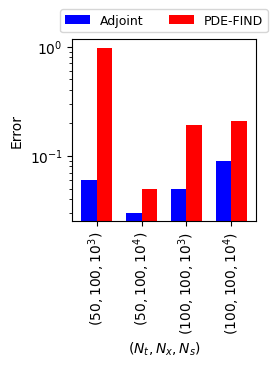

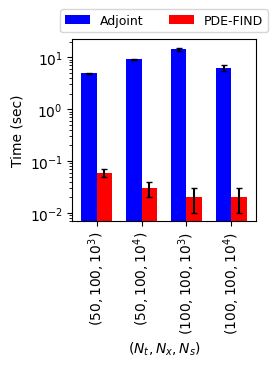

In [269]:
err_adjoint = np.array([0.06,  0.03,  0.05, 0.09  ])
err_pdefind = np.array([0.98,  0.05,  0.19, 0.21  ])

t_adjoint = np.array([4.9,  9.1,  14.3, 6.3 ])
t_pdefind = np.array([0.06 ,  0.03, 0.02, 0.02])
t_adjoint_bars = np.array([0.1,  0.2,  1.1, 0.8 ])
t_pdefind_bars = np.array([0.01,  0.01 ,  0.01, 0.01])

discr_ = [r'$(50,100,10^3)$', r'$(50,100,10^4)$', r'$(100,100,10^3)$', r'$(100,100,10^4)$']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x, N_s)$')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "RandomWalkError"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)


plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, t_adjoint, color='blue', width=bar_width, capsize=2, label=r"Adjoint", yerr=t_adjoint_bars)
plt.bar(bar_positions2, t_pdefind, color='red', width=bar_width, capsize=2, label=r"PDE-FIND", yerr=t_pdefind_bars)
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(N_t, N_x, N_s)$')
plt.ylabel('Time (sec)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "RandomWalkTime"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## Sensitivity to noise

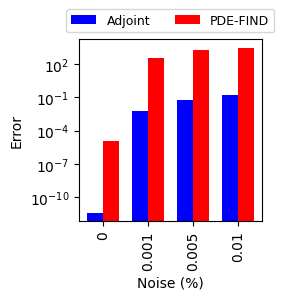

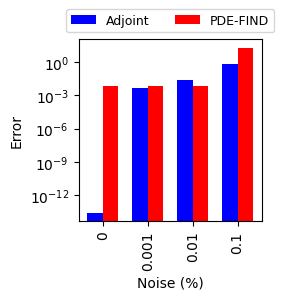

In [197]:
## Heat Equation

noise_percent = np.array([0, 0.001, 0.005, 0.01])
err_adjoint_heat_eq = np.array([3.9e-12,  0.0058,  0.060,   0.15  ])
err_pdefind_heat_eq = np.array([1.2e-5 ,  309.17,  1880.2,  2951.2])

discr_ = ['0', '0.001', '0.005', '0.01']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint_heat_eq, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind_heat_eq, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'Noise (%)')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "noise_time_adjoint_pdefind_heat_eq"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

## Burgers' equation

noise_percent = np.array([0, 0.001, 0.01, 0.1])
err_adjoint_heat_eq = np.array([2.5e-14,  0.0050,  0.0261,   0.708  ])
err_pdefind_heat_eq = np.array([0.0071 ,  0.00718,  0.0069,  20.92])

discr_ = ['0', '0.001', '0.01', '0.1']

bar_width = 0.35
bar_positions1 = np.arange(len(discr_))
bar_positions2 = bar_positions1 + bar_width

plt.figure(figsize=(size*cm, size*cm))
plt.bar(bar_positions1, err_adjoint_heat_eq, color='blue', width=bar_width, capsize=2, label=r"Adjoint")
plt.bar(bar_positions2, err_pdefind_heat_eq, color='red', width=bar_width, capsize=2, label=r"PDE-FIND")
plt.xticks(rotation=90)
plt.xticks(bar_positions1 + bar_width / 2, discr_)
plt.yscale('log')
plt.legend()
plt.xlabel(r'Noise (%)')
plt.ylabel('Error')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=9)
name = "noise_time_adjoint_pdefind_burgers"
plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)


plt.show()
